In [ ]:
install.packages('NHPoisson',dependencies = T)
library(NHPoisson)

In [ ]:
tB <- BarTxTn$ano + rep(c(0:152) / 153,55)
time<-tB
feature<-BarTxTn$Tx
time.features<-cbind(time,feature)
colnames(time.features)<-c('time','obs')#DO NOT CHANGE THE COLUMNS NAME
par(mfrow=c(1,2))
op<-diplot(time.features)
ones<-rep(1,length(op$DI)-1)
diff<-op$DI[1:length(op$DI)-1] - ones * mean(op$DI[1:length(op$DI)-1])

abline(v=mean(op$thresh),col='red')
abline(v=op$thresh[match(max(op$DI[1:length(op$DI)-1]),op$DI)],col='blue')
abline(v=op$thresh[which.min(abs(diff))],col='green')

thresh1<-mean(op$thresh)#is the mean threshold
thresh2<-op$thresh[match(max(op$DI[1:length(op$DI)-1]),op$DI)]#mode threshold
thresh3<-op$thresh[which.min(abs(diff))]

In [ ]:
import sys
sys.path.insert(0,'../input/gaussianprocesses/GPy/')

# Load Libraries and Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
import graphviz
from sklearn import tree

In [2]:
test = pd.read_csv('../input/data-without-drift/test_clean.csv')
train = pd.read_csv('../input/data-without-drift/train_clean.csv')
train.shape,test.shape

((5000000, 3), (2000000, 2))

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold


## What data was recorded?  
The electrical signal and maximum number of channels open constitute a data instance.
## How was the data collected? 
One data instance is recorded every 0.1 milli-second. So, in one second there are 10,000 data instances recorded.  
The data was recorded in batches of 50 seconds. Therefore, one batch contains 500,000 rows.  
Training data contains 10 batches: 5 million rows  
Test data contains 4 batches: 2 million rows  

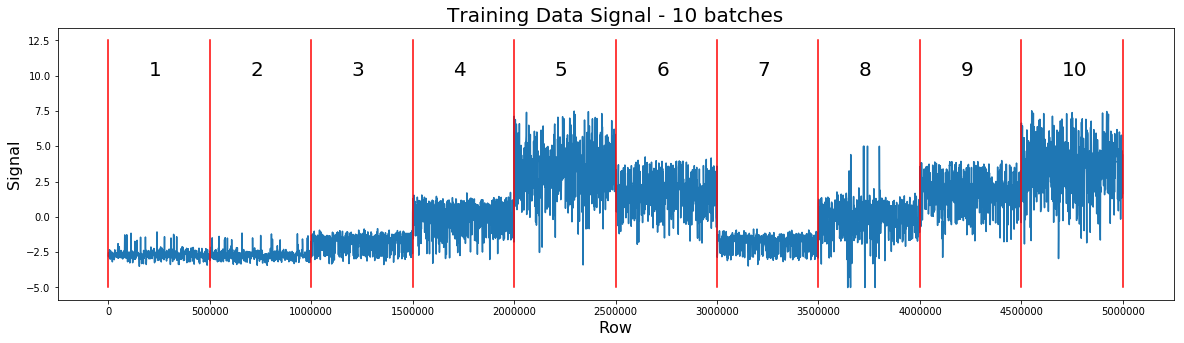

In [34]:
plt.figure(figsize=(20,5)); res = 1000
plt.xticks(np.arange(0, 5500000, step=500000))
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

## Can I rearrange the batches? Is batch1 collected prior to batch2 and so on & so forth? 

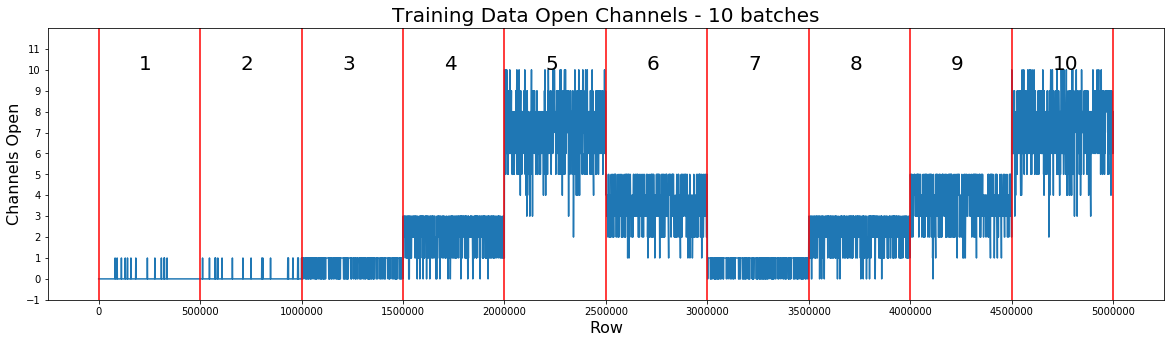

In [33]:
plt.figure(figsize=(20,5)); res = 1000
plt.ylim(bottom=-1);plt.ylim(top=12)
plt.yticks(np.arange(-1, 12, step=1))
plt.xticks(np.arange(0, 5500000, step=500000))
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); 
plt.ylabel('Channels Open',size=16); 
plt.title('Training Data Open Channels - 10 batches',size=20)
plt.show()

The channels are classified broadly into 2 categories depending on whether they have a low-probability of opening(low conductance) or a high-probability of opening(high conductance):-  
1.Batch1 and Batch2 represent low-probability channels: binary classification.>>>>Model1  
2.Other Batches represnet high-probabaility channels: multi-class classification.>>>>Model2

## Analysis from above EDA:-  
From the plots above, it looks like they used 5 different synthetic models.   
One model produced maximum 1 open channel with low probability (batches 1 and 2).   
One model produced maximum 1 open channel with high probability (batches 3 and 7).   
One model produced maximum 3 open channels (batches 4 and 8).   
One model produced maximum 5 open channels (batches 6 and 9) and  
One model produced maximum 10 open channels (batches 5 and 10).   

According to the paper [here][1], the data is synthesized. Also "electrophysiological" noise and drift were added.  
Drift is a signal bias causing the signal to no longer be a horizontal line like batches 2, 7, 8, 9, 10.

> Data description and dataset construction. Ion channel dwell-times were
simulated using the method of Gillespie 43 from published single channel models.
Channels are assumed to follow a stochastic Markovian process and transition
from one state to the next simulated by randomly sampling from a lifetime
probability distribution calculated for each state. Authentic “electrophysiological”
noise was added to these events by passing the signal through a patch-clamp
amplifier and recording it back to file with CED’s Signal software via an Axon
electronic “model cell”. In some datasets additional drift was applied to the final
data with Matlab. Two different stochastic gating models, (termed M1 and M2)
were used to generate semi-synthetic ion channel data. M1 is a low open probability model from ref. 41 (Fig. 3a, b), typically no more than one ion channel opens
simultaneously. Model M2 is from refs. 42,44 and has a much higher open probability (Fig. 3c, d), consequently up to five channels opened simultaneously and there are few instances of zero channels open.


[1]: https://www.nature.com/articles/s42003-019-0729-3


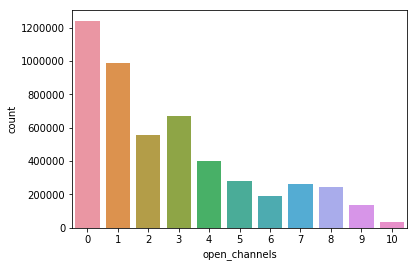

In [41]:
import seaborn as sns
sns.countplot(train['open_channels'])

# Correlation Between Signal and Open Channels
Let's look closely at random intervals of signal and open channels to observe how they relate. We notice that they are highly correlated and move up and down together. Therefore we can probabily predict open channels from the one feature signal. The only complication is the synthetic drift that was added.

#########################
### Random 4498417 to 4503417
#########################


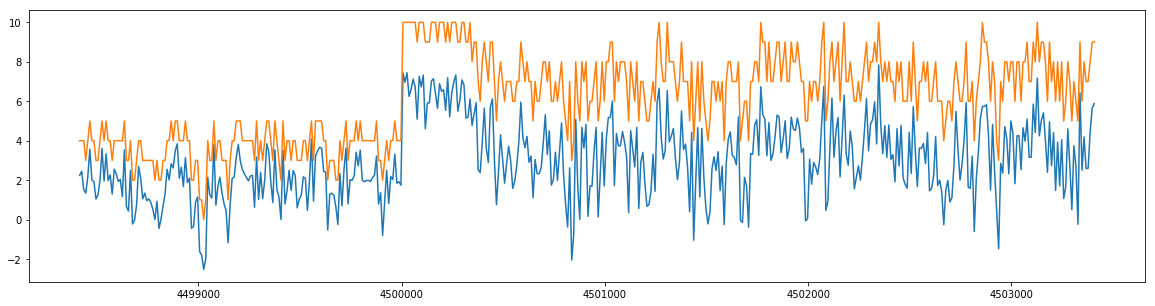

#########################
### Random 2125428 to 2130428
#########################


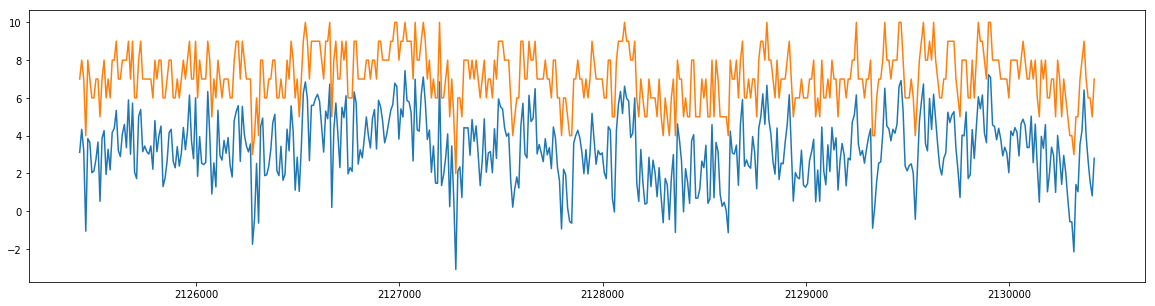

#########################
### Random 1078231 to 1083231
#########################


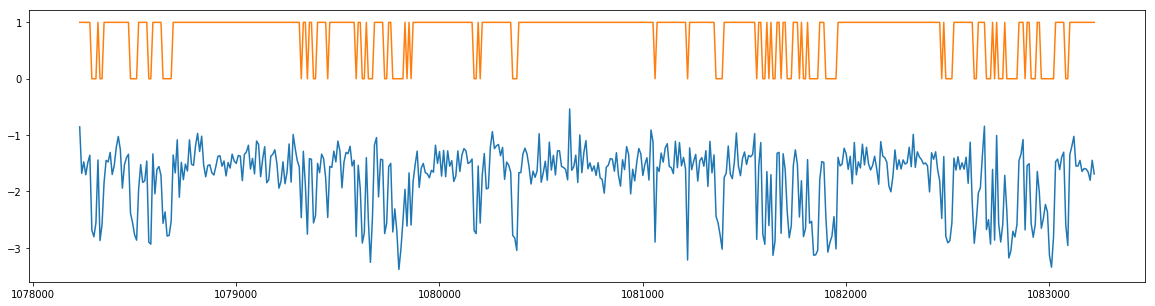

#########################
### Random 2101659 to 2106659
#########################


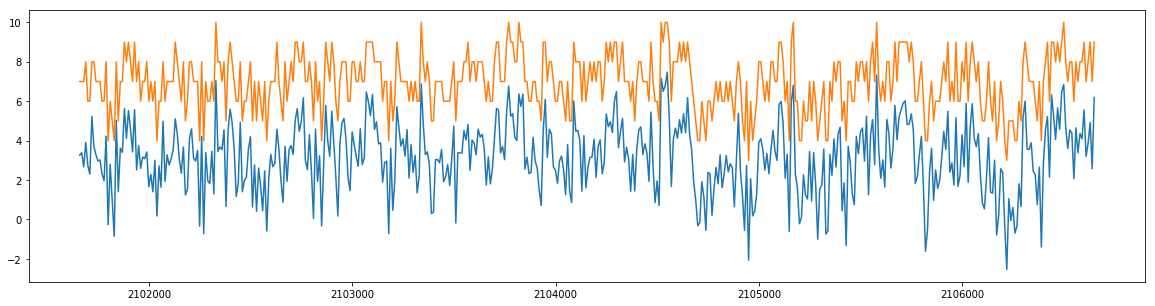

#########################
### Random 3551541 to 3556541
#########################


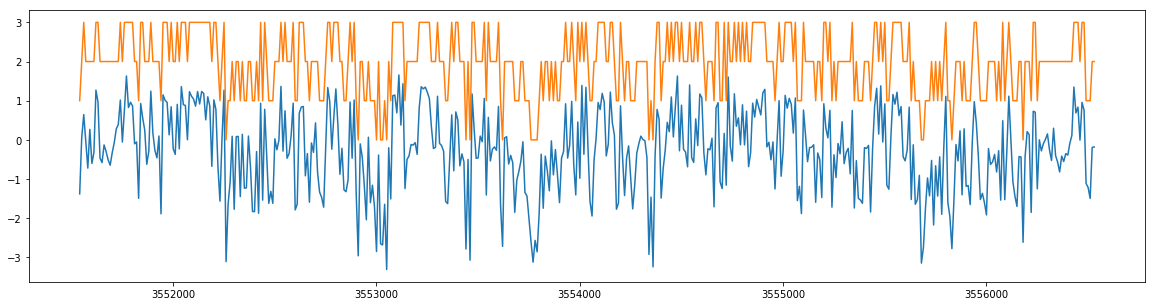

#########################
### Random 155214 to 160214
#########################


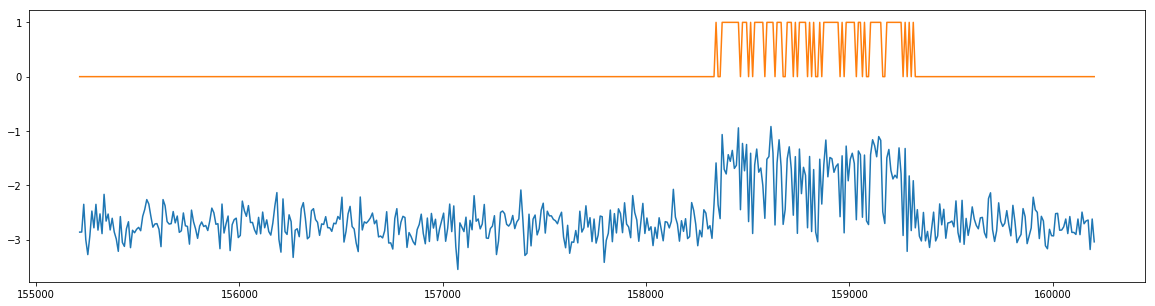

#########################
### Random 4231741 to 4236741
#########################


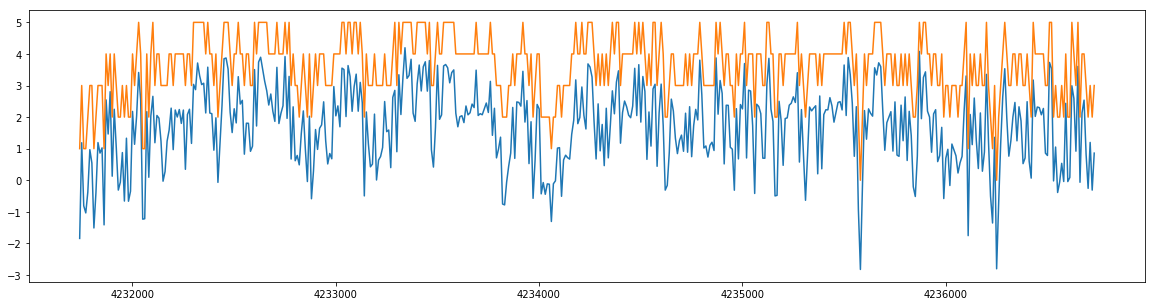

#########################
### Random 4858697 to 4863697
#########################


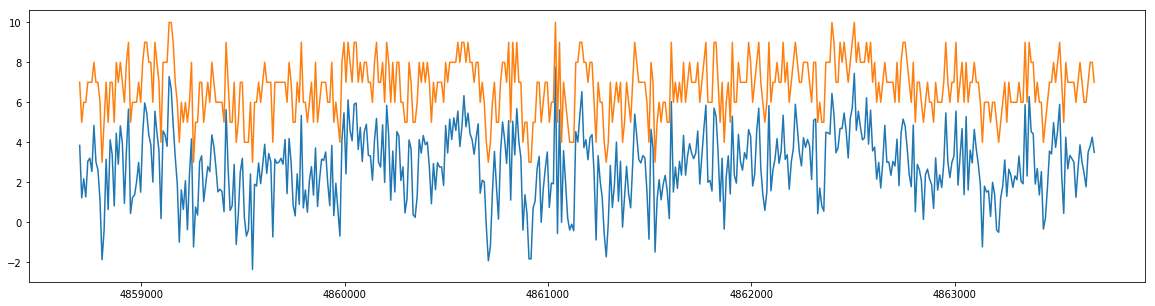

#########################
### Random 1606777 to 1611777
#########################


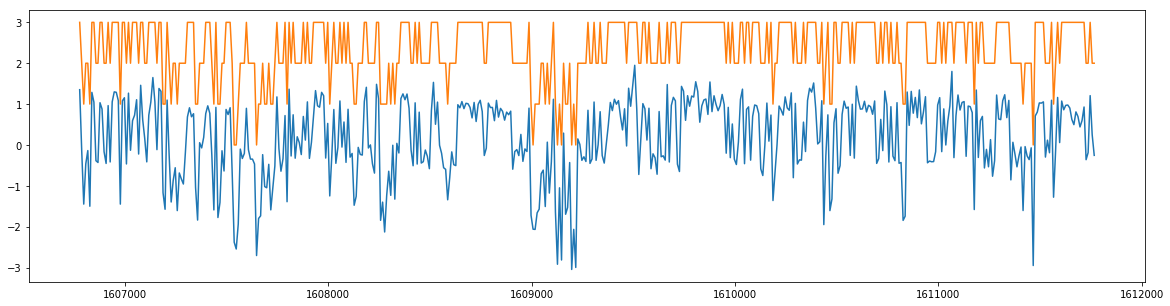

#########################
### Random 186982 to 191982
#########################


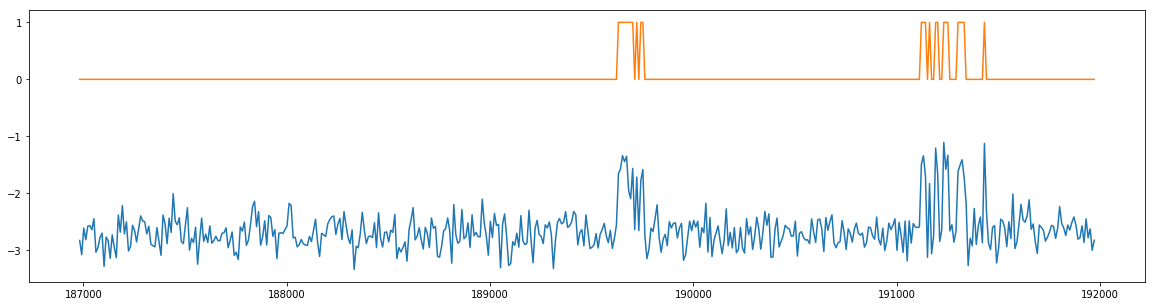

In [12]:
for k in range(10):
    a = int( np.random.uniform(0,train.shape[0]-50000) )
    b=a+5000; res=10
    print('#'*25)
    print('### Random %i to %i'%(a,b))
    print('#'*25)
    plt.figure(figsize=(20,5))
    plt.plot(range(a,b,res),train.signal[a:b][0::res])
    plt.plot(range(a,b,res),train.open_channels[a:b][0::res])
    plt.show()

# Test Data
Let's display the test data signal

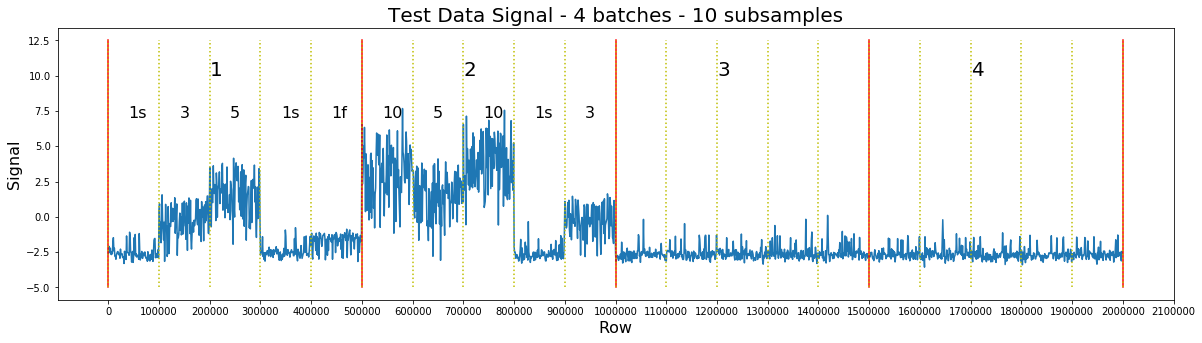

In [29]:
plt.figure(figsize=(20,5))
plt.xticks(np.arange(0, 2500000, step=100000))
res = 1000; let = ['1s', '3', '5', '1s','1f','10','5','10','1s','3']
plt.plot(range(0,test.shape[0],res),test.signal[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(21): plt.plot([j*100000,j*100000],[-5,12.5],'y:')
for k in range(4): plt.text(k*500000+200000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7,let[k],size=16)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Test Data Signal - 4 batches - 10 subsamples',size=20)
plt.show()

## Analysis of EDA above:-  
From this plot we can locate the 5 models in action. 

## Niz approach: Make 2 models:-  
1.for low-probability channels : batch1,batch2 in training data  
2.for high-probability channels: batch3 to batch10 in training data

In [43]:
train2 = train.copy()

### 1) low probability model

X_train.shape,y_train.shape: (1000000, 1) (1000000, 1)


(array([964796.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  35204.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

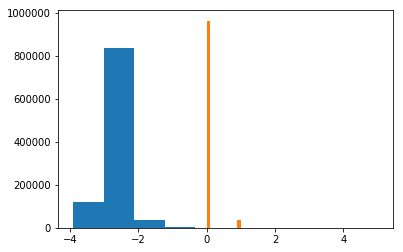

In [74]:
X_train = np.asarray(train2.signal.values[0:1000000]).reshape((-1,1))
y_train = np.asarray(train2.open_channels.values[0:1000000]).reshape((-1,1))
print('X_train.shape,y_train.shape:',X_train.shape,y_train.shape)
plt.hist(X_train)
plt.hist(y_train)

Training model low-probability channel
f1 validation score = 0.9836712205100422


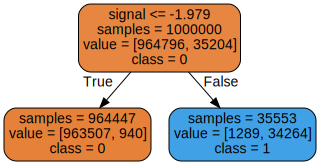

In [75]:
clf1s = tree.DecisionTreeClassifier(max_depth=1,criterion='entropy')
clf1s = clf1s.fit(X_train,y_train)
print('Training model low-probability channel')
preds = clf1s.predict(X_train)
print('f1 validation score =',f1_score(y_train,preds,average='macro'))
tree_graph = tree.export_graphviz(clf1s, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)  

### 2)high probability model

X_train.shape,y_train.shape: (4000000, 1) (4000000, 1)


(array([275356., 950661., 553924., 668609., 403410., 277877., 188112.,
        265015., 245183., 171853.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

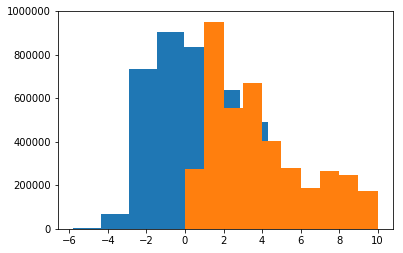

In [76]:
X_train = np.asarray(train2.signal.values[1000000:]).reshape((-1,1))
y_train = np.asarray(train2.open_channels.values[1000000:]).reshape((-1,1))
print('X_train.shape,y_train.shape:',X_train.shape,y_train.shape)
plt.hist(X_train)
plt.hist(y_train)

In [ ]:

# multi-class classification with Keras
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


from sklearn import datasets
iris = datasets.load_iris()
X = train2.signal.values[1000000:]
Y = train2.open_channels.values[1000000:]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(8, input_dim=1, activation='relu'))
	model.add(Dense(11, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [77]:
high_clf = tree.DecisionTreeClassifier(criterion='entropy')
high_clf = high_clf.fit(X_train,y_train)
print('Training model high-probability channel')
preds = clf1s.predict(X_train)
print('f1 validation score =',f1_score(y_train,preds,average='macro'))
tree_graph = tree.export_graphviz(high_clf, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1','2','3','4','5','6','7','8','9','10'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)  

Training model high-probability channel
f1 validation score = 0.12099190706211896


# Make Five Simple Models
We will make one model for each different type of signal we observed above.

In [ ]:
train2 = train.copy()

## 1 Slow Open Channel--batch1 and batch2

In [ ]:
batch = 1; a = 500000*(batch-1); b = 500000*batch
batch = 2; c = 500000*(batch-1); d = 500000*batch
X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf1s = tree.DecisionTreeClassifier(max_depth=1)
clf1s = clf1s.fit(X_train,y_train)
print('Training model 1s channel')
preds = clf1s.predict(X_train)
print('has f1 validation score =',f1_score(y_train,preds,average='macro'))
print('X_train.shape,y_train.shape: ',X_train.shape,y_train.shape)
tree_graph = tree.export_graphviz(clf1s, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)  

## 1 Fast Open Channel

In [ ]:
batch = 3; a = 500000*(batch-1); b = 500000*batch
batch = 7; c = 500000*(batch-1); d = 500000*batch
X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf1f = tree.DecisionTreeClassifier(max_depth=1)
clf1f = clf1f.fit(X_train, y_train)
print('Training model 1f channel')
preds = clf1f.predict(X_train)
print('has f1 validation score =',f1_score(y_train,preds,average='macro'))

tree_graph = tree.export_graphviz(clf1f, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph) 

In [ ]:
X_train.shape,y_train.shape

## 3 Open Channels

In [ ]:
batch = 4; a = 500000*(batch-1); b = 500000*batch
batch = 8; c = 500000*(batch-1); d = 500000*batch
X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf3 = tree.DecisionTreeClassifier(max_leaf_nodes=4)
clf3 = clf3.fit(X_train,y_train)
print('Training model 3 channel')
preds = clf3.predict(X_train)
print('has f1 validation score =',f1_score(y_train,preds,average='macro'))

tree_graph = tree.export_graphviz(clf3, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1','2','3'],
    rounded = True, filled= True )
graphviz.Source(tree_graph) 

## 5 Open Channels

In [ ]:
batch = 6; a = 500000*(batch-1); b = 500000*batch
batch = 9; c = 500000*(batch-1); d = 500000*batch
X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf5 = tree.DecisionTreeClassifier(max_leaf_nodes=6)
clf5 = clf5.fit(X_train, y_train)
print('Trained model 5 channel')
preds = clf5.predict(X_train)
print('has f1 validation score =',f1_score(y_train,preds,average='macro'))

tree_graph = tree.export_graphviz(clf5, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = ['0', '1','2','3','4','5'],
    rounded = True, filled= True )
graphviz.Source(tree_graph) 

## 10 Open Channels

In [ ]:
batch = 5; a = 500000*(batch-1); b = 500000*batch
batch = 10; c = 500000*(batch-1); d = 500000*batch
X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))

clf10 = tree.DecisionTreeClassifier(max_leaf_nodes=8)
clf10 = clf10.fit(X_train, y_train)
print('Trained model 10 channel')
preds = clf10.predict(X_train)
print('has f1 validation score =',f1_score(y_train,preds,average='macro'))

tree_graph = tree.export_graphviz(clf10, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['signal'], class_names = [str(x) for x in range(11)],
    rounded = True, filled= True )
graphviz.Source(tree_graph) 

# Analyze Test Data Drift
Let's plot the drift in the training and test data

## Training Data Drift
We observe drift whereever the following plot is not a horizontal line. We see drift in batches 2, 7, 8, 9, 10.

In [ ]:
# ORIGINAL TRAIN DATA
plt.figure(figsize=(20,5))
r = train.signal.rolling(30000).mean()
plt.plot(train.time.values,r)
for i in range(11): plt.plot([i*50,i*50],[-3,8],'r:')
for j in range(10): plt.text(j*50+20,6,str(j+1),size=20)
plt.title('Training Signal Rolling Mean. Has Drift wherever plot is not horizontal line',size=16)
plt.show()

# TRAIN DATA WITHOUT DRIFT
plt.figure(figsize=(20,5))
r = train2.signal.rolling(30000).mean()
plt.plot(train2.time.values,r)
for i in range(11): plt.plot([i*50,i*50],[-3,8],'r:')
for j in range(10): plt.text(j*50+20,6,str(j+1),size=20)
plt.title('Training Signal Rolling Mean without Drift',size=16)
plt.show()

## Test Data Drift
We observe drift in test subsamples A, B, E, G, H, I and test batch 3.


In [ ]:
plt.figure(figsize=(20,5))
let = ['A','B','C','D','E','F','G','H','I','J']
r = test.signal.rolling(30000).mean()
plt.plot(test.time.values,r)
for i in range(21): plt.plot([500+i*10,500+i*10],[-3,6],'r:')
for i in range(5): plt.plot([500+i*50,500+i*50],[-3,6],'r')
for k in range(4): plt.text(525+k*50,5.5,str(k+1),size=20)
for k in range(10): plt.text(505+k*10,4,let[k],size=16)
plt.title('Test Signal Rolling Mean. Has Drift wherever plot is not horizontal line',size=16)
plt.show()

# Predict Test


1s ---> atmost 1 open channel with low prob  
1f ---> atmost 1 open channel with high prob  
 3 ---> atmost 3 open channels with high prob  
 5 ---> atmost 5 open channels with high prob  
10 ---> atmost 10 open channels with high prob  

In [ ]:
sub = pd.read_csv('../input/liverpool-ion-switching/sample_submission.csv')

a = 0 # SUBSAMPLE A, Model 1s
sub.iloc[100000*a:100000*(a+1),1] = clf1s.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 1 # SUBSAMPLE B, Model 3
sub.iloc[100000*a:100000*(a+1),1] = clf3.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 2 # SUBSAMPLE C, Model 5
sub.iloc[100000*a:100000*(a+1),1] = clf5.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 3 # SUBSAMPLE D, Model 1s
sub.iloc[100000*a:100000*(a+1),1] = clf1s.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 4 # SUBSAMPLE E, Model 1f
sub.iloc[100000*a:100000*(a+1),1] = clf1f.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 5 # SUBSAMPLE F, Model 10
sub.iloc[100000*a:100000*(a+1),1] = clf10.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 6 # SUBSAMPLE G, Model 5
sub.iloc[100000*a:100000*(a+1),1] = clf5.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 7 # SUBSAMPLE H, Model 10
sub.iloc[100000*a:100000*(a+1),1] = clf10.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 8 # SUBSAMPLE I, Model 1s
sub.iloc[100000*a:100000*(a+1),1] = clf1s.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

a = 9 # SUBSAMPLE J, Model 3
sub.iloc[100000*a:100000*(a+1),1] = clf3.predict(test2.signal.values[100000*a:100000*(a+1)].reshape((-1,1)))

 # BATCHES 3 AND 4 seem to be generated from Model 1s
sub.iloc[1000000:2000000,1] = clf1s.predict(test2.signal.values[1000000:2000000].reshape((-1,1)))

# Display Test Predictions

In [ ]:
plt.figure(figsize=(20,5))
res = 1000
plt.plot(range(0,test.shape[0],res),sub.open_channels[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for i in range(21): plt.plot([i*100000,i*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+250000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7.5,let[k],size=16)
plt.title('Test Data Predictions',size=16)
plt.show()

In [ ]:
sub.to_csv('submission.csv',index=False,float_format='%.4f')

In [ ]:
sub['open_channels'].hist()